## Yelp Data Initial Exploration - Business Data

In [50]:
## preps
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os

In [52]:


def generate_top_frequency_plot(data, variable, top_n, chart_title):
    # Extracting categories from the specified variable
    categories_count = {}

    for category in data[variable].values:
        if category is not None:
            all_categories = category.split(",")
            all_categories = [x.strip() for x in all_categories]

            for x in all_categories:
                categories_count[x] = categories_count.get(x, 0) + 1

    # Creating a DataFrame from the category count dictionary
    top_categories_df = pd.DataFrame.from_dict(data=categories_count, orient="index")
    top_categories_df.reset_index(inplace=True)
    top_categories_df.columns = ['category', 'occurrence']

    # Extracting the top N categories for plotting
    top_categories = top_categories_df.sort_values("occurrence")[::-1][:top_n]

    # Extracting values and labels for the pie chart
    x_values = top_categories.occurrence.values
    labels = top_categories.category.values

    # Creating a Series and plotting a pie chart
    series = pd.Series(x_values, index=labels, name=chart_title)
    series.plot.pie(figsize=(10, 10), startangle=90)

    

## Business Data preview

In [51]:
# load and preview the data
business_data = []
with open("/Users/kalhan/Downloads/yelp_academic_dataset_business.json") as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)
business_df.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [74]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [4]:

business_df = business_df.rename(columns = {'name': 'business_name'})

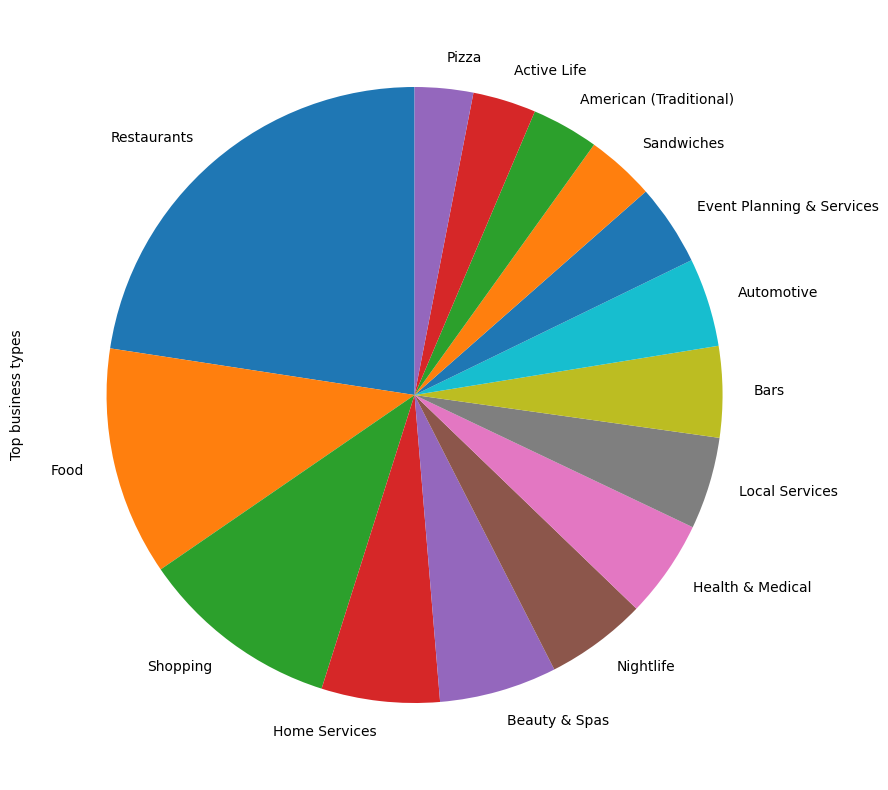

In [53]:
## Top 15 business ategories
generate_top_frequency_plot(business_df,"categories",15,"Top business types")

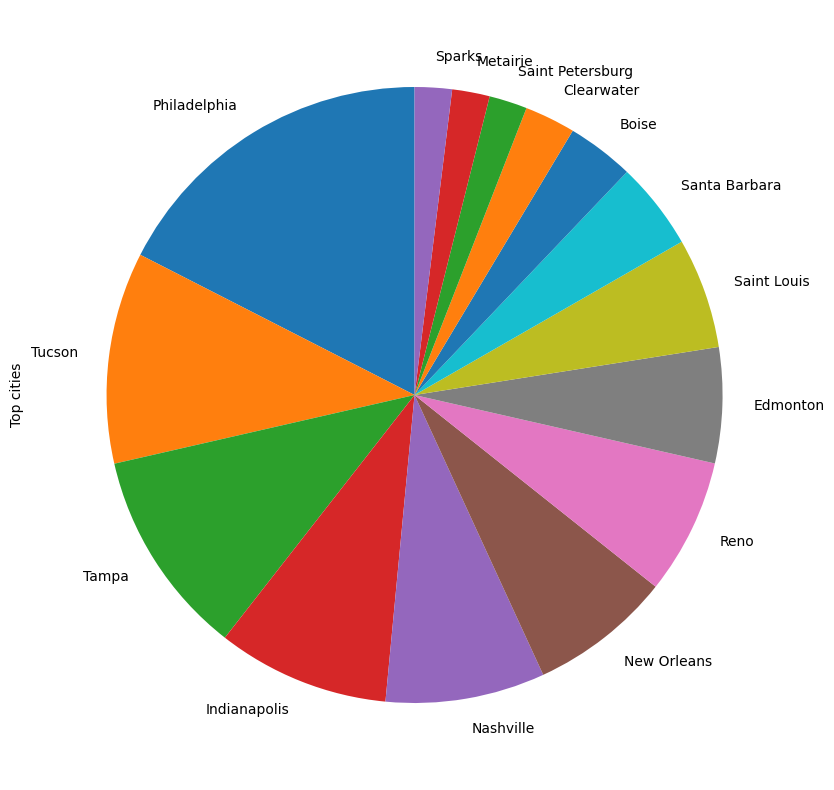

In [54]:
## top cities
generate_top_frequency_plot(business_df,"city",15,"Top cities")

In [55]:
restaurants = (business_df["categories"].str.find("Restaurants")>=0)


In [56]:
restaurants.sum()

52268

* We only focus on restaurants to avoid matrix sparsity

In [57]:
foods_df = business_df[restaurants]
print(foods_df.shape)
foods_df.head()

(52268, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


- __Second, We focus on cities where the reviews per business is high__

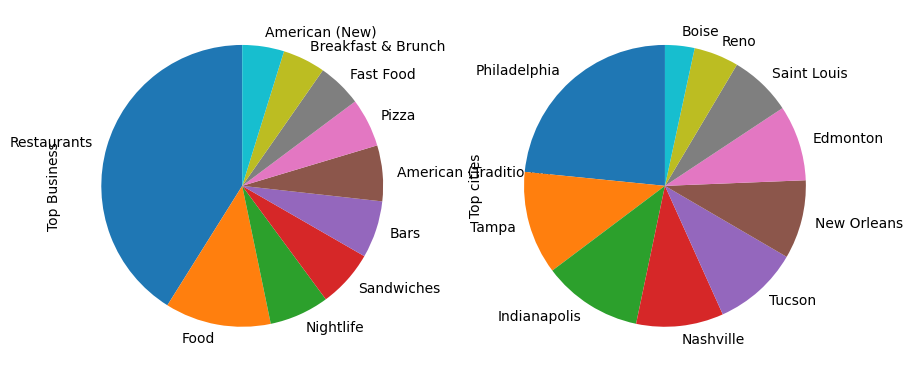

In [58]:
plt.subplot(1,2,1)
generate_top_frequency_plot(foods_df,"categories",10,"Top Business")
plt.subplot(1,2,2)
generate_top_frequency_plot(foods_df,"city",10,"Top cities")

## WE PLOT THE TOP 15 CITIES WITH MOST NUMBER OF REVIEWS

/var/folders/rk/5qrwfd812f94v60p04y5t27m0000gn/T/ipykernel_31306/3150245450.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  review_count = foods_df.groupby("city", as_index=False)["review_count"].agg(sum).sort_values(by = "review_count", ascending = False)


Text(0.5, 1.0, 'top review counts')

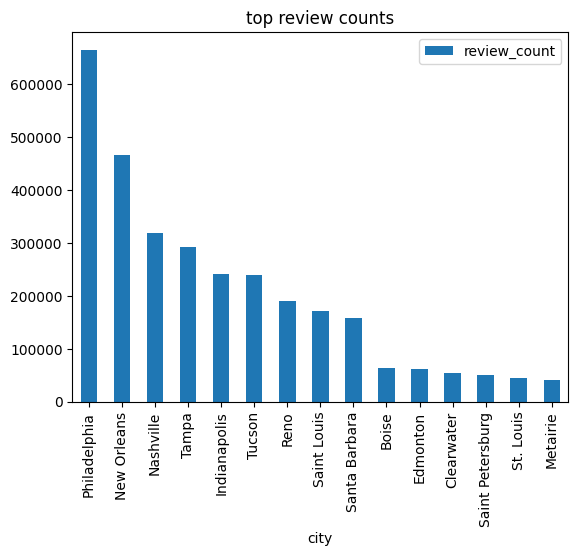

In [59]:
## restaurant review counts by city
review_count = foods_df.groupby("city", as_index=False)["review_count"].agg(sum).sort_values(by = "review_count", ascending = False)
top_reviews = review_count.iloc[:15]
top_reviews = top_reviews.set_index("city")
top_reviews.plot.bar()
plt.title("top review counts")

In [23]:
top_reviews

,review_count
city,
Philadelphia,665732
New Orleans,465982
Nashville,318548
Tampa,293122
Indianapolis,242024
Tucson,238851
Reno,191003
Saint Louis,171777
Santa Barbara,158247


## Finalize our candidate cities:

In [64]:
## For simplicity, we choose the top 5 cities by review counts
candidates = top_reviews.iloc[:5]
print(candidates.index.values)

['Philadelphia' 'New Orleans' 'Nashville' 'Tampa' 'Indianapolis']


In [65]:
df_res_business = foods_df[foods_df["city"].isin(candidates.index.values)]
df_res_business.to_csv("business_data_subset.csv", index = None)

In [28]:
df_res_business.head()

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."


In [29]:
df_res_bus = pd.read_csv("business_data_subset.csv", index_col= None)
df_res_bus_ids = df_res_bus.business_id.unique()
df_res_bus.head()

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107.0,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207.0,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227.0,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106.0,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
4,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147.0,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."


(16435, 14)
Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'number of restaurants')

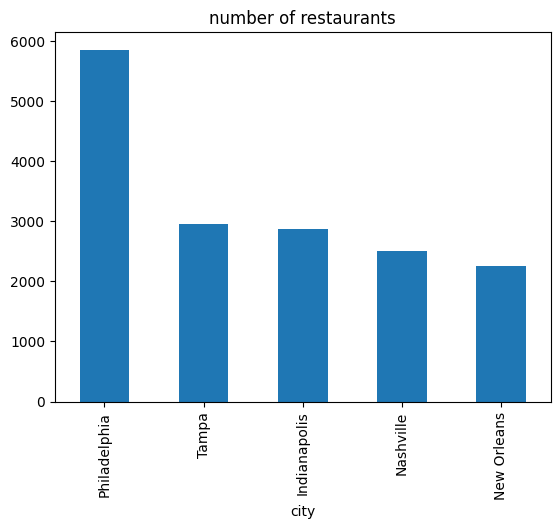

In [30]:
print(df_res_bus.shape)
print(df_res_bus.groupby(["city"])["business_id"].size().sort_values(ascending = False).plot.bar())
plt.title("number of restaurants")

## Review Data

In [ ]:
###### WE process only 1e7 reviews. More reviews can be used be used if given more compute.
'''
# THIS CELL HAS ALREADY BEEN EXECUTED
review_data_samp = []
count = 0
count_cap = 1e7 #### TODO, 
count = 0
with open("/Users/kalhan/Downloads/yelp_academic_dataset_review.json") as f:
    for i,line in enumerate(f):
        print(i)
        if i > count_cap:
            break 
        if json.loads(line)["business_id"] in df_res_bus_ids:
            review_data_samp.append(json.loads(line))   
review_df_samp = pd.DataFrame.from_dict(review_data_samp)
review_df_samp.to_csv("reviews_data_subset.csv", index=None)
'''

In [32]:
reviews_df = pd.read_csv("reviews_data_subset.csv")
reviews_df.head()
reviews_df.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
1,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
3,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14


In [33]:
print(reviews_df.shape)
df_merge = pd.merge(reviews_df, df_res_bus[['city','categories', 'business_id',"review_count"]], how = "outer", on ="business_id")
df_merge.head()


(2043247, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Philadelphia,"Halal, Pakistani, Restaurants, Indian",181
1,HME_ksGph3se7Aze5hxa-Q,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2.0,0,0,1,Dine-in gets 2 stars. Disappointing service & ...,2014-07-13 17:25:47,Philadelphia,"Halal, Pakistani, Restaurants, Indian",181
2,EJWyA5wpdVMji1j4TwSZqQ,mqBWACmaHflW4eh_Ofp16Q,kxX2SOes4o-D3ZQBkiMRfA,5.0,13,6,5,After a long hiatus from reviewing I have awak...,2010-08-20 19:16:04,Philadelphia,"Halal, Pakistani, Restaurants, Indian",181
3,T_kAb2NeylB-JdNDKphryw,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,1,1,We've eaten here 3 times and it seems that eac...,2017-01-02 14:25:26,Philadelphia,"Halal, Pakistani, Restaurants, Indian",181
4,NENaCqb6TNj5CyY1LOdI6Q,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5.0,0,0,0,Came to Philly for a family event but stayed a...,2015-07-28 17:15:20,Philadelphia,"Halal, Pakistani, Restaurants, Indian",181


In [34]:
df_merge.isnull().sum()

review_id       0
user_id         0
business_id     0
stars           0
useful          0
funny           0
cool            0
text            0
date            0
city            0
categories      0
review_count    0
dtype: int64

In [35]:
df_merge.dropna(inplace=True)

In [36]:
df_merge.city.unique()

array(['Philadelphia', 'New Orleans', 'Indianapolis', 'Tampa',
       'Nashville'], dtype=object)

In [37]:
x = df_merge.groupby(["city","user_id"]).size().reset_index()
print("users' reviews summary statistics")
x.groupby("city").describe()

users' reviews summary statistics


0                                                
                 count      mean        std  min  25%  50%  75%    max
city                                                                  
Indianapolis   77467.0  3.234655   9.646812  1.0  1.0  1.0  2.0  541.0
Nashville     139681.0  2.331928   5.753778  1.0  1.0  1.0  2.0  408.0
New Orleans   201798.0  2.360881   5.944015  1.0  1.0  1.0  2.0  727.0
Philadelphia  209513.0  3.280412  10.296483  1.0  1.0  1.0  2.0  929.0
Tampa         114328.0  2.652299   8.320370  1.0  1.0  1.0  2.0  666.0

Text(0.5, 1.0, 'Average reviews per User')

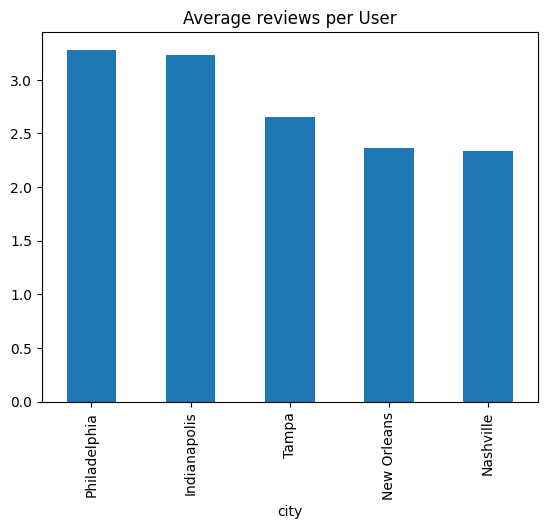

In [38]:
x.groupby("city").describe()[(0, "mean")].sort_values(ascending = False).plot.bar()
plt.title("Average reviews per User")

## User Data

In [39]:

users_ids_subset = df_merge.user_id.unique().tolist()

In [40]:
print(len(users_ids_subset))

697386


In [44]:
print(df_merge.shape)
df_merge_filtered_philly = df_merge[df_merge["city"]=="Philadelphia"]
print(df_merge_filtered_philly.shape)

(2043247, 12)
(687289, 12)


In [46]:
users_ids_subset_philly = df_merge_filtered_philly.user_id.unique().tolist()
print(len(users_ids_subset_philly))
users_ids_subset_philly = set(users_ids_subset_philly)

209513


WE HAVE AROUND 200K UNIQUE USERS FOR REVIEWS OF philadelphia   ITSELF. We filter down the user-dataset to choose only users who occur in the merged dataset

In [47]:
user_data_samp = []
with open("/Users/kalhan/Downloads/yelp_academic_dataset_user.json") as f:
    for line in f:
        if json.loads(line)["user_id"] in users_ids_subset_philly:
            user_data_samp.append(json.loads(line))
            
user_data_samp = pd.DataFrame.from_dict(user_data_samp)
user_data_samp.to_csv("user_df.csv", index=None)

In [48]:
len(user_data_samp)

209513

In [49]:
user_data_samp.head()


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,163,191,361,147,1212,5696,2543,2543,815,323
3,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,...,0,0,0,0,1,6,3,3,0,0
4,1McG5Rn_UDkmlkZOrsdptg,Teresa,7,2009-05-26 16:11:11,18,3,13,,"piejMEdRkGB7-1aL4lL5NQ, X0zFOU6iG95-feQKOXkgrA...",1,...,0,0,0,0,1,0,2,2,0,0


In [70]:
user_data_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28313 entries, 0 to 28312
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             28313 non-null  object 
 1   name                28313 non-null  object 
 2   review_count        28313 non-null  int64  
 3   yelping_since       28313 non-null  object 
 4   useful              28313 non-null  int64  
 5   funny               28313 non-null  int64  
 6   cool                28313 non-null  int64  
 7   elite               28313 non-null  object 
 8   friends             28313 non-null  object 
 9   fans                28313 non-null  int64  
 10  average_stars       28313 non-null  float64
 11  compliment_hot      28313 non-null  int64  
 12  compliment_more     28313 non-null  int64  
 13  compliment_profile  28313 non-null  int64  
 14  compliment_cute     28313 non-null  int64  
 15  compliment_list     28313 non-null  int64  
 16  comp